# W207 Final Project (Baseline): Zillow Prize: Zillow’s Home Value Prediction

* Gray Selby
* Amir Moazami
* Soroush Yazdani

In this competition, Zillow has requested participants to predict the log-error between their Zestimate and the actual sale price of homes, using all available features. The log error is calculated as the logarithm of the Zestimate divided by the logarithm of the SalePrice:

**logerror = log(Zestimate) - log(SalePrice)**

We have been provided with a comprehensive dataset containing real estate properties from three counties in California: Los Angeles, Orange, and Ventura, for the year 2016.

The training data consists of all property transactions that occurred before October 15, 2016, as well as some transactions that took place after that date.

The test data available in the public leaderboard includes the remaining transactions that occurred between October 15 and December 31, 2016.

The rest of the test data, which is used to calculate the private leaderboard scores, encompasses all the properties sold between October 15, 2017, and December 15, 2017. This particular period is referred to as the "sales tracking period," during which no submissions will be accepted.

Our objective is to make predictions for six specific time points across all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

When a property is sold multiple times within a 31-day period, we will consider the first reasonable value as the ground truth. The notion of "reasonable" entails selecting the transaction with a value that appears more accurate if the data seems questionable.

To begin, we will import the necessary libraries and obtain the dataset from Kaggle.com. Subsequently, we will conduct exploratory data analysis (EDA) to enhance the cleanliness of the dataset. Finally, we will employ basic machine learning techniques to establish a baseline model.









In [1]:
# Import the libraries we'll use below.
import os 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
from scipy import stats
from scipy.stats import norm, skew #for some statistics 

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings('ignore') 

In [2]:
# set numpy random dseed
np.random.seed(42)
# instantiate numpy random number generator
rng = np.random.default_rng(42)

In [3]:
# Import our utilities.py file 
import importlib
import utilities
importlib.reload(utilities)
from utilities import *

In [4]:
# Instantiate 
ZD = ZillowData(r"C:\Users\grays\OneDrive\Berkeley DS\Courses\207 ML\Final Project\Zillow Dataset")

# Load the Data

Check the method get_data() in utilities.py for the implementation. 

In [5]:
ZD.get_data()
ZD.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 60 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   parcelid                      167888 non-null  int64  
 1   logerror                      167888 non-null  float64
 2   transactiondate               167888 non-null  object 
 3   airconditioningtypeid         53788 non-null   float64
 4   architecturalstyletypeid      468 non-null     float64
 5   basementsqft                  93 non-null      float64
 6   bathroomcnt                   167854 non-null  float64
 7   bedroomcnt                    167854 non-null  float64
 8   buildingclasstypeid           31 non-null      float64
 9   buildingqualitytypeid         107173 non-null  float64
 10  calculatedbathnbr             166056 non-null  float64
 11  decktypeid                    1272 non-null    float64
 12  finishedfloor1squarefeet      12893 non-null

### Check for duplicate entries

In [6]:
ZD.check_for_duplicates()

Number of duplicates IDs: 0 / 167888


# Train, Validation, Test Split

We have ensured that each row is unique so we will randomly select 70% of the rows for the train set and split the remaining rows between validation and test sets.

In [7]:
ZD.train_val_test_split(train_prob=0.7)

Train set ratio: 0.70
Validation set ratio: 0.15
Test set ratio: 0.15


## The regression prediction targets

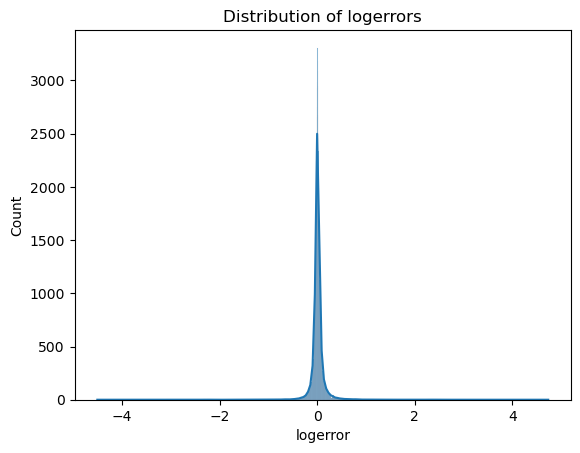

In [8]:
ZD.plot_logerr_hist(df=ZD.train)

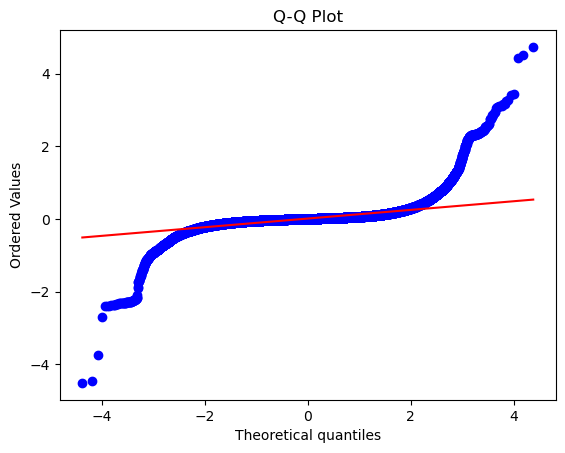

In [9]:
ZD.plot_logerr_QQ(df=ZD.train)

Given the presence of outliers, let us remove extreme examples more than 3 standard deviations from the mean.

In [10]:
def remove_outliers(data_df, n_stds=3):
    len_df = data_df.shape[0]
    high_thresh = data_df.logerror.mean() + n_stds * data_df.logerror.std()
    low_thresh = data_df.logerror.mean() - n_stds * data_df.logerror.std()
    trimmed_df = data_df[data_df.logerror < high_thresh]
    trimmed_df = trimmed_df[data_df.logerror > low_thresh]
    
    len_trimmed = trimmed_df.shape[0]
    print(f'{len_df - len_trimmed} of {len_df} outliers removed.')
    
    return trimmed_df

In [11]:
trimmed_train = remove_outliers(ZD.train, n_stds=3)

1746 of 117521 outliers removed.


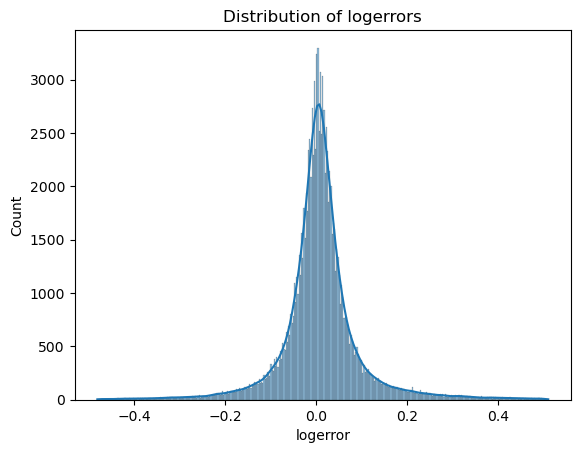

In [12]:
ZD.plot_logerr_hist(df=trimmed_train)

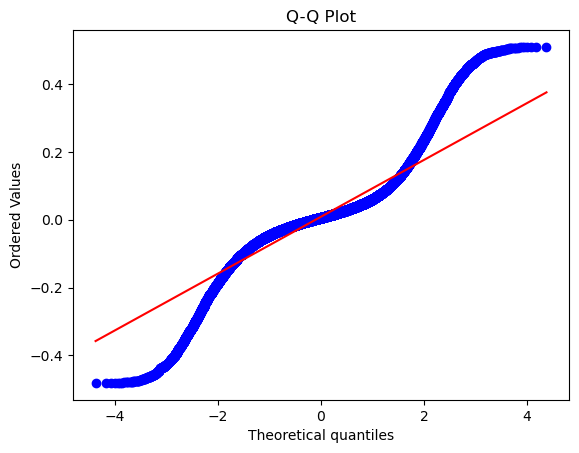

In [13]:
ZD.plot_logerr_QQ(df=trimmed_train)

Now we update the train set after the outliers were removed. We do not touch the validation or test sets as that would be improper. The point of removing extreme outliers from the train set is to allow our models to focus on learning the general trend instead of trying to accomodate outlier cases.

In [14]:
ZD.train = trimmed_train

Next form the datasets by separating the X data from the Y targets.

In [15]:
ZD.form_datasets()

In [35]:
# Mean absolute error
ZD.train_y.logerror.mad()

0.05555839178693465

In [36]:
# Root mean squared error
ZD.train_y.logerror.std()

0.08985725090283397

In [16]:
print(f'Train X shapes:      {ZD.train_x.shape}, Y shapes: {ZD.train_y.shape}')
print(f'Validation X shapes: {ZD.val_x.shape},  Y shapes: {ZD.val_y.shape}')
print(f'Test X shapes:       {ZD.test_x.shape},  Y shapes: {ZD.test_y.shape}')

Train X shapes:      (115775, 59), Y shapes: (115775, 2)
Validation X shapes: (25184, 59),  Y shapes: (25184, 2)
Test X shapes:       (25183, 59),  Y shapes: (25183, 2)


## Missing data

In [28]:
train_na_ratio_df = ZillowData.get_missing_ratio_df(ZD.train_x)

Unfortunately nearly half of the data is missing.

In [33]:
print(f'Average percent of missing data per column: {train_na_ratio_df.NAN_ratio.mean()*100:.1f}%')

Average percent of missing data per column: 49.2%


Each column's missing data ratio is shown below.

In [27]:
train_na_ratio_df

,NAN_ratio
buildingclasstypeid,0.999845
finishedsquarefeet13,0.999594
basementsqft,0.999447
storytypeid,0.999447
yardbuildingsqft26,0.998955
fireplaceflag,0.997659
architecturalstyletypeid,0.997132
typeconstructiontypeid,0.996804
finishedsquarefeet6,0.995483
decktypeid,0.992477


In [19]:
acceptable_missing_features = feature_na_ratio_df[feature_na_ratio_df.NAN_ratio < 0.5]
acceptable_missing_features

,NAN_ratio
heatingorsystemtypeid,0.369311
buildingqualitytypeid,0.361460
propertyzoningdesc,0.351829
unitcnt,0.350343
lotsizesquarefeet,0.110430
finishedsquarefeet12,0.048344
regionidcity,0.020039
calculatedbathnbr,0.010391
fullbathcnt,0.010391
yearbuilt,0.006020


drop: finishedsquarefeet12, propertyzoningdesc

In [20]:
'fireplacecnt' in acceptable_missing_features.index

False

In [21]:
acceptable_missing_features

,NAN_ratio
heatingorsystemtypeid,0.369311
buildingqualitytypeid,0.361460
propertyzoningdesc,0.351829
unitcnt,0.350343
lotsizesquarefeet,0.110430
finishedsquarefeet12,0.048344
regionidcity,0.020039
calculatedbathnbr,0.010391
fullbathcnt,0.010391
yearbuilt,0.006020


In [22]:
print(ZD.train_x.propertyzoningdesc.unique().shape)
print(ZD.train_x.propertycountylandusecode.unique().shape)
print(ZD.train_x.propertylandusetypeid.unique().shape)

(2132,)
(80,)
(14,)


In [23]:
ZD.accepted_features_list(lst=acceptable_missing_features)

In [24]:
tmpdf = ZD.train_x
print(tmpdf.shape)
trimmed = tmpdf[acceptable_missing_features.index.to_list()]
print(trimmed.shape)
trimmed

(115775, 59)
(115775, 28)


,heatingorsystemtypeid,buildingqualitytypeid,propertyzoningdesc,unitcnt,lotsizesquarefeet,finishedsquarefeet12,regionidcity,calculatedbathnbr,fullbathcnt,yearbuilt,...,propertylandusetypeid,fips,longitude,roomcnt,latitude,regionidcounty,assessmentyear,bedroomcnt,bathroomcnt,propertycountylandusecode
81426,NaN,NaN,NaN,NaN,5850.0,1293.0,13091.0,1.5,1.0,1956.0,...,261.0,6111.0,-119250191.0,5.0,34443619.0,2061.0,2015.0,2.0,1.5,1110
24147,NaN,7.0,HAR3YY,2.0,5601.0,NaN,42150.0,2.0,2.0,1956.0,...,246.0,6037.0,-118340006.0,0.0,33912311.0,3101.0,2015.0,4.0,2.0,0200
350,2.0,NaN,LAC4,1.0,NaN,1270.0,12447.0,2.0,2.0,2009.0,...,266.0,6037.0,-118326000.0,0.0,34100600.0,3101.0,2015.0,1.0,2.0,01HC
116369,2.0,7.0,WDR4*,1.0,71290.0,1197.0,48424.0,2.0,2.0,1974.0,...,266.0,6037.0,-118383000.0,0.0,34093200.0,3101.0,2016.0,2.0,2.0,010E
42742,2.0,7.0,GLR1YY,1.0,6082.0,2051.0,45457.0,2.0,2.0,1948.0,...,261.0,6037.0,-118210557.0,0.0,34151146.0,3101.0,2015.0,3.0,2.0,0100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166915,2.0,8.0,LBR1S,1.0,4771.0,2014.0,46298.0,2.0,2.0,1936.0,...,261.0,6037.0,-118127706.0,0.0,33762143.0,3101.0,2016.0,3.0,2.0,0100
81221,7.0,7.0,PAR2*,1.0,6069.0,1191.0,6395.0,2.0,2.0,1955.0,...,261.0,6037.0,-118174802.0,0.0,33898584.0,3101.0,2015.0,3.0,2.0,0100
150420,NaN,NaN,NaN,NaN,13073.0,NaN,16764.0,1.0,1.0,1955.0,...,261.0,6059.0,-117936292.0,6.0,33850176.0,1286.0,2016.0,3.0,1.0,122
105117,NaN,4.0,LRMDR 2*,1.0,7779.0,1025.0,5534.0,1.0,1.0,1947.0,...,261.0,6037.0,-118130434.0,0.0,34702036.0,3101.0,2016.0,1.0,1.0,0100


In [25]:
pd.DataFrame(trimmed.columns)

,0
0,heatingorsystemtypeid
1,buildingqualitytypeid
2,propertyzoningdesc
3,unitcnt
4,lotsizesquarefeet
5,finishedsquarefeet12
6,regionidcity
7,calculatedbathnbr
8,fullbathcnt
9,yearbuilt
